In [1]:
# Step 1 : Train neural baseline model, and robust neural model. 

In [1]:
import sys
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/")
sys.path.append("/Users/skrishna/Documents/phd_codes/neurips_paper/")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR")
sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/Generative_Model")


sys.path.append("/Users/satyaprk/Documents/intern_codes/robustness_vs_counterfactuals/Recourse_Methods/AR/recourse/")


In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn as nn

import ML_Models.data_loader as loader
# from Recourse_Methods.gradient_methods import SCFE
# from utils import get_recourses, get_performance_measures


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
## Dataset Prep


from torchvision import  datasets, transforms
from torch.utils.data import DataLoader

n_starting_instances = 1200


data_name = "adult"
adult_dict = {
        "data_path": "../Data_Sets/Adult/",
        "filename_train": 'adult-train.csv',
        "filename_test": 'adult-test.csv',
        "label": 'income',
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 25,
        "H2": 25,
        "activFun": nn.Softplus(),
        "n_starting_instances": n_starting_instances
    }

german_dict = {
        "data_path": './German_Credit_Data/',
        "filename_train": 'german-train.csv',
        "filename_test": 'german-test.csv',
        "label": "risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
    }


compas_dict = {
        "data_path": './COMPAS/',
        "filename_train": 'compas-train.csv',
        "filename_test": 'compas-test.csv',
        "label": "risk",
        "task": "classification",
        "lr": 1e-3,
        "d": 6,
        "H1": 10,
        "H2": 10,
    }


data_meta_dictionaries = {
        "compas": compas_dict,
        "adult":adult_dict, 
        "german":german_dict
    }
data_meta_info = data_meta_dictionaries[data_name]


dataset_test = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                 filename=data_meta_info["filename_test"],
                                                 label=data_meta_info["label"]) #, scale = 'standard')
        
dataset_train = loader.DataLoader_Tabular(path=data_meta_info["data_path"],
                                                  filename=data_meta_info["filename_train"],
                                                  label=data_meta_info["label"]) #, scale = 'standard')




In [4]:
# Data loader

train_loader = DataLoader(dataset_train, batch_size = 32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size = 32, shuffle=False)

data = [i for i in train_loader]
num_feats = len(data[0][0][0])



In [5]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Text(0, 0.5, 'Output')

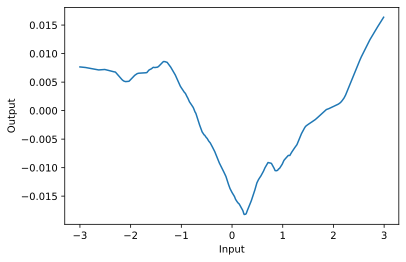

In [6]:
torch.manual_seed(0)
model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")



In [7]:
# def epoch_adversarial(model, loader, attack, opt = None):
#     total_loss, total_err = 0.,0.
#     for X,y,ind in loader:
#         X,y = X.to(device).to(torch.float32), y.to(device)
#         delta = attack(model, X, y, *args)
#         yp = model(X+delta)
#         loss = nn.CrossEntropyLoss()(yp,y)
#         if opt:
#             opt.zero_grad()
#             loss.backward()
#             opt.step()        
#         total_err += (yp.max(dim=1)[1] != y).sum().item()
#         total_loss += loss.item() * X.shape[0]
#     return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X.to(torch.float32))
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [9]:
## Baseline Neural Model 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.Sequential(nn.Linear(num_feats,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,2))

opt = optim.SGD(model.parameters(), lr=1e-2)
for _ in range(50):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")



0.247561	0.506393	0.235489	0.437731
0.201896	0.416000	0.202764	0.408140
0.187799	0.391705	0.185849	0.387543
0.174752	0.372370	0.181647	0.372706
0.171490	0.361579	0.175898	0.362405
0.170467	0.357514	0.175124	0.364660
0.170744	0.354771	0.173134	0.355384
0.169472	0.352711	0.172139	0.354163
0.168422	0.350853	0.171918	0.351602
0.166929	0.349006	0.173134	0.353200
0.166680	0.347561	0.170149	0.351769
0.166321	0.346140	0.172139	0.356373
0.164939	0.344473	0.168049	0.347517
0.164580	0.343128	0.166390	0.345026
0.164165	0.342311	0.173355	0.355821
0.162120	0.341450	0.170260	0.355095
0.160765	0.339683	0.174019	0.360063
0.161207	0.339163	0.162410	0.342040
0.160572	0.338262	0.162852	0.337808
0.159604	0.337797	0.161747	0.336590
0.159079	0.337734	0.164842	0.344490
0.159466	0.336505	0.166280	0.346031
0.158803	0.335406	0.162852	0.338068
0.158471	0.334362	0.164290	0.342549
0.159217	0.334858	0.161747	0.338667
0.157890	0.333490	0.187507	0.422327
0.157918	0.332917	0.159093	0.333082
0.158443	0.333265	0.164400	0

In [10]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()



def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


In [11]:
torch.save(model, "./models/{}_ann_model.pth".format(data_name))


In [12]:
# Perturbation Method 
"""TODO(satya): docstring."""
import torch


class BasePerturbation:
    """Base Class for perturbation methods."""

    def __init__(self, data_format):
        """Initialize generic parameters for the perturbation method."""
        assert data_format == "tabular", "Currently, only tabular data is supported!"
        self.data_format = data_format

    def get_perturbed_inputs(self,
                             original_sample: torch.FloatTensor,
                             feature_mask: torch.BoolTensor,
                             num_samples: int,
                             feature_metadata: list,
                             max_distance: int = None) -> torch.tensor:
        """Logic of the perturbation methods which will return perturbed samples.
        This method should be overwritten.
        """


class NormalPerturbation(BasePerturbation):
    """TODO(satya): docstring.
    TODO(satya): Should we scale the std. based on the size of the feature? This could lead to
    some odd results if the features aren't scaled the same and we apply the same std noise
    across all the features.
    """

    def __init__(self,
                 data_format,
                 mean: float = 0.0,
                 std: float = 0.05,
                 flip_percentage: float = 0.3):
        """Init.
        Args:
            data_format: A string describing the format of the data, i.e., "tabular" for tabular
                         data.
            mean: the mean of the gaussian perturbations
            std: the standard deviation of the gaussian perturbations
            flip_percentage: The percent of features to flip while perturbing
        """
        self.mean = mean
        self.std_dev = std
        self.flip_percentage = flip_percentage
        super(NormalPerturbation, self).__init__(data_format)

    def get_perturbed_inputs(self,
                             original_sample: torch.FloatTensor,
                             feature_mask: torch.BoolTensor,
                             num_samples: int,
                             feature_metadata: list,
                             max_distance: int = None) -> torch.tensor:
        """Given a sample and mask, compute perturbations.
        Args:
            original_sample: The original instance
            feature_mask: the indices of the...
                          TODO(satya) is the indices that are masked or unmasked?
            num_samples: number of perturbed samples.
            feature_metadata: the list of 'c' or 'd' for whether the feature is categorical or
                              discrete.
            max_distance: the maximum distance between original sample and perturbed samples.
        Returns:
            perturbed_samples: The original_original sample perturbed with Gaussian perturbations
                               num_samples times.
        """
        feature_type = feature_metadata

        message = f"mask size == original sample in get_perturbed_inputs for {self.__class__}"
        assert len(feature_mask) == len(original_sample), message

        continuous_features = torch.tensor([i == 'c' for i in feature_type])
        discrete_features = torch.tensor([i == 'd' for i in feature_type])

        # Processing continuous columns
        mean = self.mean
        std_dev = self.std_dev
        perturbations = torch.normal(mean, std_dev,
                                     [num_samples, len(feature_type)]) * continuous_features + original_sample

        # Processing discrete columns
        flip_percentage = self.flip_percentage
        p = torch.empty(num_samples, len(feature_type)).fill_(flip_percentage)
        perturbations = perturbations * (~discrete_features) + torch.abs(
            (perturbations * discrete_features) - (torch.bernoulli(p) * discrete_features))

        # keeping features static that are in top-K based on feature mask
        perturbed_samples = torch.tensor(
            original_sample) * feature_mask + perturbations * (~feature_mask)

        return perturbed_samples
    
    
    

In [ ]:
def conv_disc_inds_to_char_enc(discrete_feature_indices: list[int], n_features: int):
    """Converts an array of discrete feature indices to a char encoding.
    Here, the ith value in the returned array is 'c' or 'd' for whether the feature is
    continuous or discrete respectively.
    Args:
        discrete_feature_indices: An array like [0, 1, 2] where the ith value corresponds to
                                  whether the arr[i] column in the data is discrete.
        n_features: The number of features in the data.
    Returns:
        char_encoding: An encoding like ['c', 'd', 'c'] where the ith value indicates whether
                       that respective column in the data is continuous ('c') or discrete ('d')
    """
    # Check to make sure (1) feature indices are integers and (2) they are unique
    error_message = "Features all must be type int but are not"
    assert all(isinstance(f, int) for f in discrete_feature_indices), error_message
    error_message = "Features indices must be unique but there are repetitions"
    assert len(set(discrete_feature_indices)) == len(discrete_feature_indices), error_message
    # Perform conversion
    char_encoding = ['e'] * n_features
    for i in range(len(char_encoding)):
        if i in discrete_feature_indices:
            char_encoding[i] = 'd'
        else:
            char_encoding[i] = 'c'
    # In case something still went wrong
    assert 'e' not in char_encoding, 'Error in char encoding processing!'
    return char_encoding


In [38]:
epsilon = 0.9
perturbation_method = NormalPerturbation("tabular",mean=0,std=epsilon,
                                flip_percentage=0.03)


    
    
    
def epoch_adversarial(model, loader, attack, epsilon, opt = None):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X,y = X.to(device).to(torch.float32), y.to(device)
        delta = attack(model, X, y, epsilon)
        augmented_samples = attack_normal(X, y, epsilon)
        for perturbation in [torch.zeros_like(X, requires_grad=True), delta]:
            yp = model(X+perturbation)
            loss = nn.CrossEntropyLoss()(yp,y)
            if opt:
                opt.zero_grad()
                loss.backward()
                opt.step()        
            total_err += (yp.max(dim=1)[1] != y).sum().item()
            total_loss += loss.item() * X.shape[0]
    return total_err / (len(loader.dataset)*2), total_loss / (len(loader.dataset)*2)

# print("2-layer DNN:", epoch_adversarial(model, test_loader, fgsm, 0.1)[0])

model_robust = nn.Sequential(nn.Linear(num_feats,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,2))

opt = optim.SGD(model_robust.parameters(), lr=1e-4)
for _ in range(50):
    train_err, train_loss = epoch_adversarial(model_robust, train_loader, fgsm, epsilon,  opt)
    test_err, test_loss = epoch_adversarial(model_robust, test_loader, fgsm, epsilon )
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")


    

0.427772	0.699170	0.420232	0.533213
0.364195	0.475209	0.158983	0.461344
0.157075	0.453246	0.155113	0.444262
0.167261	0.472648	0.166943	0.470693
0.171670	0.473426	0.168325	0.475614
0.163833	0.437325	0.162576	0.443585
0.163142	0.429998	0.160033	0.416210
0.158112	0.411324	0.156219	0.410599
0.156550	0.411310	0.157048	0.404840
0.157089	0.403515	0.155224	0.398518
0.155513	0.393458	0.156661	0.394371
0.157047	0.398298	0.168159	0.428290
0.159245	0.398793	0.167164	0.422237
0.159494	0.396528	0.155445	0.386180
0.157434	0.391292	0.156993	0.392704
0.157780	0.393227	0.166390	0.410329
0.151008	0.372580	0.149309	0.369896
0.150897	0.369922	0.148701	0.370285
0.150399	0.368988	0.176396	0.425492
0.149930	0.364997	0.175290	0.413981
0.152942	0.369660	0.152957	0.367273
0.150551	0.357980	0.148203	0.349118
0.143434	0.341831	0.140741	0.337196
0.139619	0.331725	0.139414	0.332724
0.138527	0.329421	0.140630	0.336625
0.139439	0.330153	0.137535	0.326251
0.138016	0.326374	0.138253	0.326876
0.138057	0.326529	0.139303	0

In [39]:
epoch_adversarial(model_robust, test_loader, fgsm, epsilon )



(0.12719734660033166, 0.2898218744012515)

In [31]:
torch.save(model_robust, "./models/{}_ann_model_ro_{}.pth".format(data_name, epsilon))


In [40]:
# Recourse Method 2
import Recourse_Methods.Generative_Model.model as model_vae
from numpy import linalg as LA

# Second class of counter-factual explanation methods         
class CCHVAE:

    def __init__(self, classifier, model_vae, target_threshold: float = 0,
                 n_search_samples: int = 10000, p_norm: int = 1,
                 step: float = 0.05, max_iter: int = 1000, clamp: bool = True):
        
        super().__init__()
        self.classifier = classifier
        self.generative_model = model_vae
        self.n_search_samples = n_search_samples
        self.p_norm = p_norm
        self.step = step
        self.max_iter = max_iter
        self.clamp = clamp
        self.target_treshold = target_threshold

    def hyper_sphere_coordindates(self, instance, high, low):
    
        """
        :param n_search_samples: int > 0
        :param instance: numpy input point array
        :param high: float>= 0, h>l; upper bound
        :param low: float>= 0, l<h; lower bound
        :param p: float>= 1; norm
        :return: candidate counterfactuals & distances
        """
    
        delta_instance = np.random.randn(self.n_search_samples, instance.shape[1])
        dist = np.random.rand(self.n_search_samples) * (high - low) + low  # length range [l, h)
        norm_p = LA.norm(delta_instance, ord=self.p_norm, axis=1)
        d_norm = np.divide(dist, norm_p).reshape(-1, 1)  # rescale/normalize factor
        delta_instance = np.multiply(delta_instance, d_norm)
        candidate_counterfactuals = instance + delta_instance
    
        return candidate_counterfactuals, dist

    def generate_counterfactuals(self, query_instance: torch.tensor, target_class: int = 1) -> torch.tensor:
        """
        :param instance: np array
        :return: best CE
        """  #

        # init step size for growing the sphere
        low = 0
        high = low + self.step

        # counter
        count = 0
        counter_step = 1
        query_instance = query_instance.detach().numpy()

        # get predicted label of instance
        self.classifier.eval()
        instance_label = 1 - target_class
        # vectorize z
        z = self.generative_model.encode_csearch(torch.from_numpy(query_instance).float()).detach().numpy()
        z_rep = np.repeat(z.reshape(1, -1), self.n_search_samples, axis=0)

        while True:
            count = count + counter_step
            if count > self.max_iter:
                candidate_counterfactual_star = np.empty(query_instance.shape[0], )
                candidate_counterfactual_star[:] = np.nan
                distance_star = -1
                print('No CE found')
                break

            # STEP 1 -- SAMPLE POINTS on hypersphere around instance
            latent_neighbourhood, _ = CCHVAE.hyper_sphere_coordindates(self, z_rep, high, low)
            
#             print("-->> ", latent_neighbourhood)
            x_ce = self.generative_model.decode_csearch(torch.from_numpy(latent_neighbourhood).float()).detach().numpy()
            
            
#             # why do we have this?
#             if self.clamp:
#                 x_ce = x_ce.clip(-1, 1)

            # STEP 2 -- COMPUTE l1 & l2 norms
            if self.p_norm == 1:
                distances = np.abs((x_ce - query_instance)).sum(axis=1)
            elif self.p_norm == 2:
                distances = LA.norm(x_ce - query_instance, axis=1)
            else:
                print('Distance not defined yet')
            
            # counterfactual labels
#             print(self.classifier(torch.from_numpy(x_ce).float()).detach().numpy())
            y_candidate = torch.stack([torch.tensor([int(i[0])]) for i in self.classifier(torch.from_numpy(x_ce).float()).detach().numpy() > 0])
#             print("Y_Cands : ", self.classifier(torch.from_numpy(x_ce).float()).detach().numpy())
            indeces = np.where(y_candidate != instance_label)[0]
#             print("Indeces : ", indeces)
            candidate_counterfactuals = x_ce[indeces]
            candidate_dist = distances[indeces]
            
            if len(candidate_dist) == 0:  # no candidate found & push search range outside
                low = high
                high = low + self.step
            elif len(candidate_dist) > 0:  # certain candidates generated
                min_index = np.argmin(candidate_dist)
                candidate_counterfactual_star = candidate_counterfactuals[min_index]
                distance_star = np.abs(candidate_counterfactual_star - query_instance).sum()
                break

#         return torch.tensor(candidate_counterfactual_star), torch.tensor(distance_star)
        return  torch.tensor(distance_star)     
    
    
    

In [41]:
def _get_input_subset(model_sub, inputs: torch.tensor,
                      subset_size: int = 100,
                      decision_threshold: float = 0) -> torch.tensor:
    
    """
    Get negatively classified inputs & return their predictions
    """
    
    yhat = (model_sub(inputs) > decision_threshold) * 1
    print(model_sub(inputs))
    check = (model_sub(inputs) < decision_threshold).detach().numpy()
    selected_indices = np.where(check)[0]
    input_subset = inputs[selected_indices]
    predicted_label_subset = yhat[selected_indices]
#     return input_subset, predicted_label_subset
    return input_subset[0:subset_size], predicted_label_subset[0:subset_size] #[0:subset_size] #[0:subset_size]

In [42]:
# Load the VAEs

vae_path = "../Recourse_Methods/Generative_Model/Saved_Models/"

input_size = dataset_train.get_number_of_features()

vae_model = model_vae.VAE_model(input_size,
                                data_meta_info['activFun'],
                                data_meta_info['d'],
                                data_meta_info['H1'],
                                data_meta_info['H2'])

data_meta_info["vae_path"] = vae_path + f"vae_{data_name}.pt"
print(data_meta_info["vae_path"])

vae_model.load_state_dict(torch.load(data_meta_info["vae_path"]))
        
testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=True)
        
trainloader = DataLoader(dataset_train,
                         batch_size=data_meta_info["n_starting_instances"],
                         shuffle=True)


# This method makes the "Manifold assumption" and uses random search in latent space
cchvae = CCHVAE(classifier=model, model_vae=vae_model, step=1.5, max_iter=10000, target_threshold=0)
cchvae_r = CCHVAE(classifier=model_robust, model_vae=vae_model, step=1.5, max_iter=10000, target_threshold=0)

# cchvae = CCHVAE(classifier=model, model_vae=vae_model, step=0.01, max_iter=10000, target_threshold=0)
# cchvae2 = CCHVAE(classifier=model_robust, model_vae=vae_model, step=0.01, max_iter=10000, target_threshold=0)

### Plot 1 : Box plot for baseline and robust models for distance, and validity. 

# inputs = torch.stack([j for i in test_loader for j in torch.unbind(i[0].to(torch.float32))][:200])






../Recourse_Methods/Generative_Model/Saved_Models/vae_adult.pt


In [43]:
cchvae_r = CCHVAE(classifier=model_robust, model_vae=vae_model, step=1.5, max_iter=10000, target_threshold=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
subset_size = 100
testloader = DataLoader(dataset_train,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model_robust, inputs, subset_size, decision_threshold=0)
print(inputs.shape)
print(inputs[0].reshape(1, -1))

distances_cchave_r = []
for i in range(len(inputs)):
    if i%10 == 0:
        print("Gotten {} done...".format(i))
    ctr_val = cchvae_r.generate_counterfactuals(
                    query_instance= inputs[i].reshape(1, -1),
                    target_class= 1 ).item()
    if ctr_val > 0:
        distances_cchave_r.append(ctr_val)
        
        

tensor([[ 0.4564, -0.5573],
        [ 0.4612, -0.5614],
        [ 0.4657, -0.5363],
        ...,
        [ 0.4575, -0.5353],
        [ 0.4662, -0.5365],
        [ 0.4617, -0.5491]], grad_fn=<AddmmBackward0>)
torch.Size([100, 13])
tensor([[0.4384, 0.1733, 1.0000, 0.0000, 0.5790, 0.5000, 0.0000, 0.0000, 1.0000,
         0.0000, 1.0000, 1.0000, 1.0000]])
Gotten 0 done...
Gotten 10 done...
Gotten 20 done...
Gotten 30 done...
Gotten 40 done...
Gotten 50 done...
Gotten 60 done...
Gotten 70 done...
Gotten 80 done...
Gotten 90 done...


In [45]:
sum(distances_cchave_r)/len(distances_cchave_r)

6.791478128433227

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
subset_size = 5
testloader = DataLoader(dataset_test,
                        batch_size=data_meta_info["n_starting_instances"],
                        shuffle=False)

data_iter = iter(testloader)
inputs, labels, indeces = data_iter.next()
inputs = inputs.to(device).float()
inputs, predicted_classes = _get_input_subset(model, inputs, subset_size, decision_threshold=0)
print(inputs.shape)
print(inputs[0].reshape(1, -1))

distances_cchave = []
for i in range(len(inputs)):
    if i%10 == 0:
        print("Gotten {} done...".format(i))
    ctr_val = cchvae.generate_counterfactuals(
                    query_instance= inputs[i].reshape(1, -1),
                    target_class= 1 ).item()
    if ctr_val > 0:
        distances_cchave.append(ctr_val)
        
# distances_cchave = [cchvae.generate_counterfactuals(
#                     query_instance= inputs[i].reshape(1, -1),
#                     target_class= 1 ).item() for i in range(subset_size)]
# for i in range(subset_size):
#     print("Processing...", i)
#     vals = cchvae.generate_counterfactuals(
#                     query_instance= inputs[i].reshape(1, -1),
#                     target_class= 1 ).item()
#     print(vals)


# print(epoch_adv(test_loader, model, delta[None,None,:,:]))


tensor([[ 3.5353, -3.3712],
        [ 1.8929, -1.7462],
        [-0.3491,  0.4683],
        ...,
        [ 0.5572, -0.4200],
        [ 1.2915, -1.1471],
        [ 0.0307,  0.1114]], grad_fn=<AddmmBackward0>)
torch.Size([1160, 13])
tensor([[0.1370, 0.1511, 0.5333, 0.0000, 0.0000, 0.1939, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 0.0000, 1.0000]])
Gotten 0 done...
Gotten 10 done...
Gotten 20 done...
Gotten 30 done...
Gotten 40 done...
Gotten 50 done...
Gotten 60 done...
Gotten 70 done...
Gotten 80 done...
Gotten 90 done...
Gotten 100 done...
Gotten 110 done...
Gotten 120 done...
Gotten 130 done...
Gotten 140 done...
Gotten 150 done...
Gotten 160 done...
Gotten 170 done...
Gotten 180 done...
Gotten 190 done...
Gotten 200 done...
Gotten 210 done...
Gotten 220 done...
Gotten 230 done...
Gotten 240 done...
Gotten 250 done...
Gotten 260 done...
Gotten 270 done...
Gotten 280 done...
Gotten 290 done...
Gotten 300 done...
Gotten 310 done...
Gotten 320 done...
Gotten 330 done...
Gotten 340

In [29]:
sum(distances_cchave)/len(distances_cchave)

6.890124835639164

In [35]:
sum(distances_cchave_r)/len(distances_cchave_r)

6.665942705869675

In [29]:
# Single pass over data 
# do a single pass over the data
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X = X.to(torch.float32)
        yp = model(X)[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

model = nn.Linear(13, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(50):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
    
    

Train Err	Train Loss	Test Err	Test Loss
0.180225	0.375226	0.209950	0.452975
0.174780	0.367324	0.176672	0.362969
0.172596	0.362492	0.178441	0.372130
0.170025	0.359093	0.176783	0.364736
0.171241	0.359322	0.171034	0.358658
0.168560	0.356660	0.170481	0.354209
0.168339	0.355007	0.167164	0.352186
0.167924	0.355794	0.173466	0.367883
0.166929	0.353345	0.165174	0.356765
0.166487	0.354659	0.190492	0.377299
0.167980	0.353574	0.167496	0.353452
0.164165	0.352639	0.184190	0.376829
0.165215	0.353880	0.164953	0.350879
0.165271	0.351569	0.169707	0.350845
0.167565	0.353623	0.167496	0.367271
0.166183	0.352653	0.171144	0.361490
0.166294	0.351253	0.167496	0.351782
0.163999	0.352103	0.200111	0.403546
0.167095	0.352703	0.163737	0.343681
0.166515	0.352490	0.165506	0.343796
0.166045	0.352454	0.184411	0.372812
0.163668	0.352129	0.169707	0.354003
0.164359	0.350812	0.174240	0.362553
0.164635	0.351725	0.180652	0.367785
0.165271	0.351560	0.165064	0.354664
0.166128	0.351662	0.167054	0.356413
0.165658	0.351810	0.1683

In [30]:
torch.save(model, "./models/{}_lr_model.pth".format(dataset_name))


In [50]:
# Specifying \delta
epsilon = 0.05
delta = epsilon * model.weight.detach().sign()


In [51]:
# Testing error on adversarial sample 
def epoch_adv(loader, model, delta):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X = X.to(torch.float32)
#         tmp = ((2*y.float()-1)[:, None]*delta.squeeze(0)).squeeze(0)
        yp = model(X-((2*y.float()-1)[:, None]*delta.squeeze(0)).squeeze(0)).squeeze(-1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))



(0.34129353233830845, 0.711540580902922)


In [49]:
# Robust model training 
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y,ind in loader:
        X = X.to(torch.float32)
        yp = model(X)[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


model_robust = nn.Linear(13, 1)
opt = optim.SGD(model_robust.parameters(), lr=1e-1)
epsilon = 0.05
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(50):
    train_err, train_loss = epoch_robust(train_loader, model_robust, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model_robust, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")
    
    

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.233242	0.455469	0.238695	0.453704
0.219532	0.443417	0.232504	0.448741
0.217320	0.441420	0.227971	0.449709
0.215303	0.440843	0.213599	0.447793
0.213782	0.440919	0.213820	0.449424
0.213506	0.441107	0.220896	0.448096
0.212870	0.440847	0.224102	0.448504
0.214280	0.441019	0.216363	0.449645
0.212787	0.441003	0.230735	0.449486
0.212815	0.440963	0.221780	0.448258
0.214446	0.440810	0.218132	0.451889
0.213285	0.440930	0.219237	0.448872
0.214031	0.440979	0.222554	0.448418
0.213644	0.441094	0.217910	0.448398
0.214556	0.440906	0.212714	0.448228
0.212594	0.441011	0.223549	0.448210
0.213589	0.441040	0.226866	0.447973
0.213451	0.440981	0.221448	0.449501
0.213893	0.440845	0.222443	0.447407
0.214086	0.440966	0.226866	0.448054
0.212925	0.441012	0.216584	0.450558
0.212538	0.440799	0.229630	0.451402
0.213257	0.441149	0.225650	0.447916
0.212511	0.440769	0.219458	0.447937
0.213782	0.440882	0.221448	0.448013
0.212898	0.440976	0.214594	0.448132
0.21

In [52]:
# Save robust model 
torch.save(model_robust, "./models/{}_lr_model_robust.pth".format(dataset_name))
